# Cumulative distance method 01

Calculating the cumulative distance traveled by a set of particle trajectories in km. The distances traveled during every timestep of the trajecotry are added together.

* Author(s): Laura Gomez Navarro
* Created on: 20/05/22
* Last updated on:

In [1]:
import time

print(time.ctime(time.time()))

Wed Jun 28 16:52:56 2023


### 0.  Imports and package versions

In [2]:
%matplotlib inline
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import xarray as xr

from matplotlib import colors 
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from collections import namedtuple
from shapely import geometry

import scipy 
from scipy import stats, optimize, interpolate

import sys
import inspect

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, cartopy, scipy

Software versions
Python 3.6.11 64bit [GCC Clang 11.0.0]
IPython 7.16.1
OS Darwin 21.6.0 x86_64 i386 64bit
numpy 1.19.2
matplotlib 3.3.2
xarray 0.16.2
cartopy 0.18.0
scipy 1.5.2
Wed Jun 28 16:53:00 2023 CEST

### 1. Loading the data

In [4]:
filedir = '../Simulations/'

In [5]:
ds = xr.open_dataset(filedir + 'toy_data_01.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:     (obs: 121, traj: 144)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

### 2. Calculating the distance

### 2.1. Loading the functions

In [7]:
sys.path.insert(0, "Functions/")

In [8]:
import cumulative_distance_01

In [9]:
print(inspect.getsource(cumulative_distance_01))

import numpy as np
from math import sin, cos, sqrt, atan2, radians, pi

def dist_km(lona, lonb, lata, latb):
    """
    Function to calculate the distance between 2 points in km
    """
    
    R = 6373.0     # approximate radius of earth in km

    lat1 = radians(lata)
    lon1 = radians(lona)
    lat2 = radians(latb)
    lon2 = radians(lonb)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

def cumulative_distance_01(ds_n, nsavedir=None):
    
    # Creating the output data array:
    dist_01 = ds_n.lon.copy() * np.nan

    # Calculating the distance traveled by every particle at every timestep:
    for tt in range(0, len(ds_n.traj)):
        lon_t = ds_n.lon[tt, :].dropna(dim='obs')
        lat_t = ds_n.lat[tt, :].dropna(dim='obs')
        
        for oo in range(1, len(lat_t)): # calculate as distance at x0 = distance at x-x0
     

### 2.2. Applying the cumulative distance function:

In [10]:
cum_dist_01 = cumulative_distance_01.cumulative_distance_01(ds)


In [11]:
cum_dist_01

<xarray.DataArray 'lon' (traj: 144, obs: 121)>
array([[  16.403774,   30.603819,   43.689835, ..., 2255.6865  ,
        2266.414   , 2266.414   ],
       [  19.366917,   38.18978 ,   56.715897, ..., 1715.984   ,
        1729.1825  , 1729.1825  ],
       [  24.746086,   56.121193,   92.32692 , ..., 1781.5177  ,
        1783.5271  , 1783.5271  ],
       ...,
       [  40.99772 ,   86.607864,  134.14404 , ..., 1845.9026  ,
        1854.615   , 1854.615   ],
       [  30.890318,   71.60733 ,  118.270065, ..., 2146.9658  ,
        2167.6208  , 2167.6208  ],
       [  14.378509,   33.60996 ,   58.250862, ..., 2269.991   ,
        2274.8174  , 2274.8174  ]], dtype=float32)
Dimensions without coordinates: traj, obs

% --> gives the cumulative distance traveled for every particle at every timesep.

### 3. Plotting the outputs

### 3.1. Plotting cumulative distance evolution in time for the first 10 particle trajectories

Text(0.5, 0, 'Date')

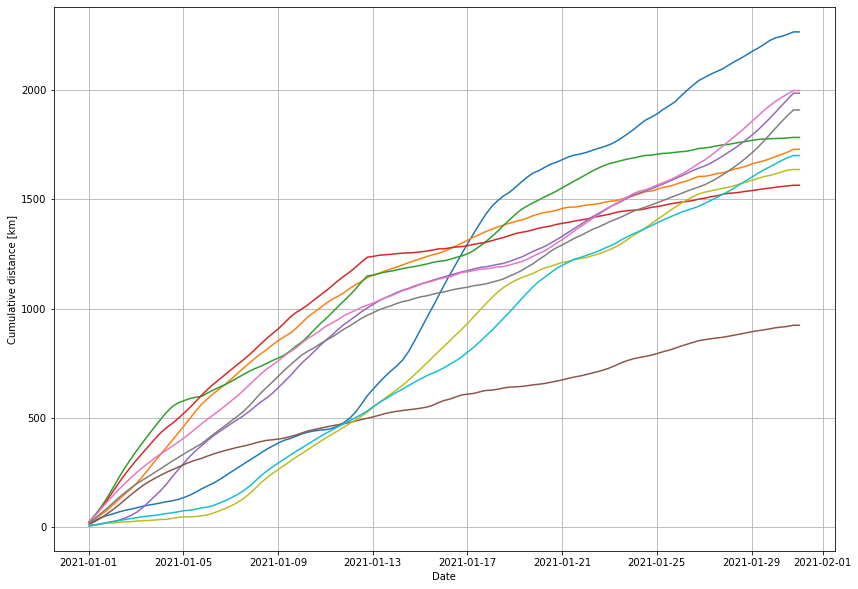

In [12]:
plt.figure(figsize=(14,10))
plt.plot(ds.time[0,:], cum_dist_01[0:10,:].T)
plt.grid()
plt.ylabel('Cumulative distance [km]')
plt.xlabel('Date')

### 3.2. Boxplot of the final cumulative distance of all the particles:

In [13]:
cum_dist_final = ((cum_dist_01.max(dim='obs')).where(cum_dist_01.max(dim='obs') != 0., drop=True)).data


In [14]:
cum_dist_final.shape

(144,)

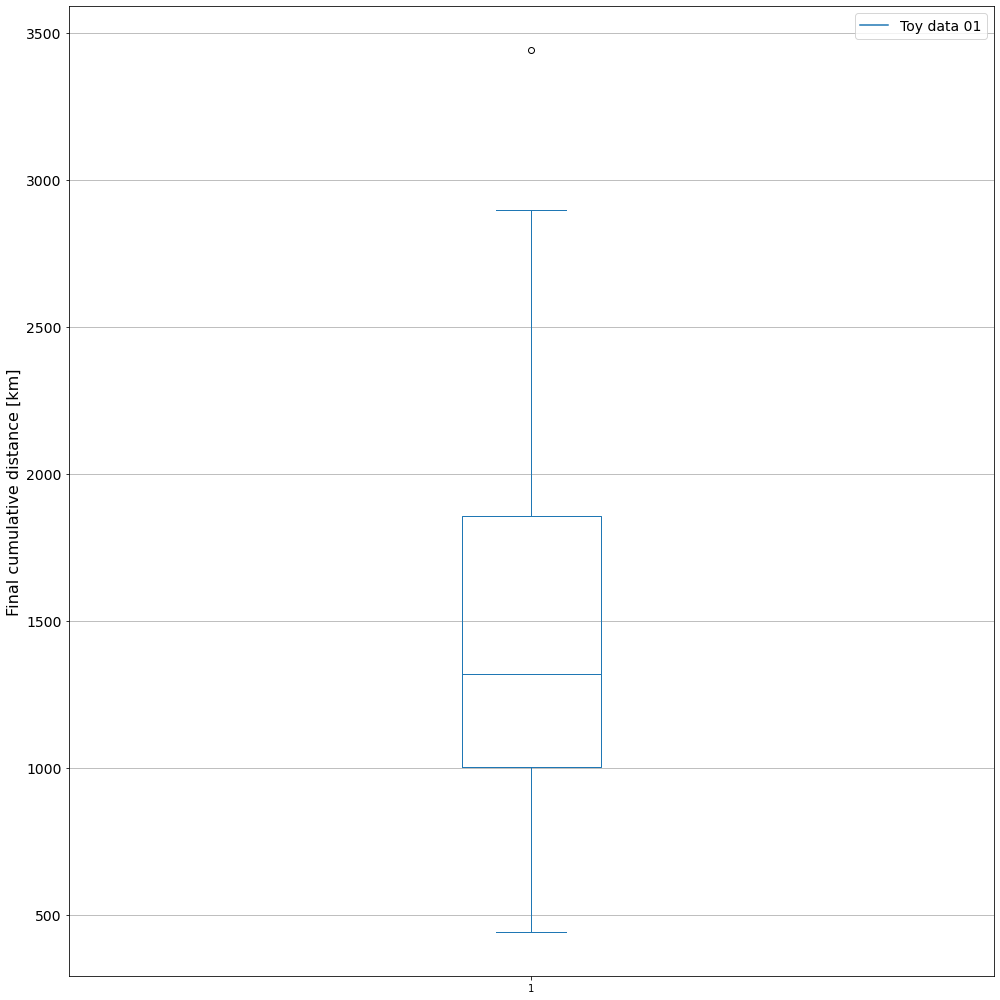

In [15]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
#     plt.setp(bp['facecolor'], color=color)

plt.figure(figsize=(14,14))
ax1 = plt.subplot(111)

bpl = ax1.boxplot(cum_dist_final) #, positions=np.array(range(len(dist_cum_a)))*2.0-0.4, sym='', widths=0.6)
set_box_color(bpl, 'C0') # colors are from http://colorbrewer2.org/

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='C0', label='Toy data 01')
# plt.plot([], c='C3', label='Tidal forcing')
plt.legend(fontsize=14)
# ax.legend(fontsize=14)

# plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 850)
# ax1.set_xticklabels(labels, rotation=45, horizontalalignment='right')
# plt.grid()
ax1.yaxis.grid()
ax1.set_ylabel('Final cumulative distance [km]', size=16)

plt.tight_layout()
# plt.savefig('figs/cumsum_km_and_total_dist_km_BOXPLOT_01.jpg', dpi=300)
plt.show()